In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl

import numpy as np
import numpy.ma as ma
import math

import tensorflow as tf
from tensorflow.keras.models import load_model

import cartopy
import cartopy.crs as ccrs

import pandas as pd

import datetime
from datetime import datetime, timedelta

from glob import glob

from tools.target_data_generator import *
from tools.predictor_data_generator import *
from tools.utils import *

import warnings
warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


# PART 1: Generate SII-NowNet Nowcast

## a) User inputs

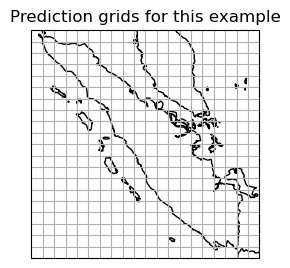

In [2]:
# These are the coordinate limits and time of the example test data
max_lon = 107
min_lon = 94.63
max_lat = 5.98
min_lat = -6.38

# number of hours into the future we want to predict
lead_time = 1

# YYYYMMDDHH of the UTC valid time (current time plus lead time)
time = '2018020109'

# this variable sets the number of himawari BT pixels within each prediction grid in the x and y direction (must be square)
# this example uses 21, resulting in prediction grids of 21x21 pixels
no_of_pixels_per_prediction_grid = 21

# visualise prediction grids
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(131, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines()
gl.xlocator=mticker.FixedLocator([min_lon + i*(max_lon - min_lon)/20 for i in range(20)])
gl.ylocator=mticker.FixedLocator([min_lat + i*(max_lat - min_lat)/20 for i in range(20)])
ax.set_title('Prediction grids for this example')
plt.show()

## b) Load data

In [3]:
# This is example data that can be used to run through the script. All fields are from across the domain set by the above min/max limits
# T_0 is the BT at the initialisation time
# T_2 is the BT 2 hours before the initialisation time
# orog_data is the orography data across the domain 

T_0_data = np.load('./tools/test_data/T_0_data.npy')
T_2_data = np.load('./tools/test_data/T_2_data.npy')
orog_data = np.load('./tools/test_data/orog_data.npy')

print(T_0_data.shape)

(420, 420)


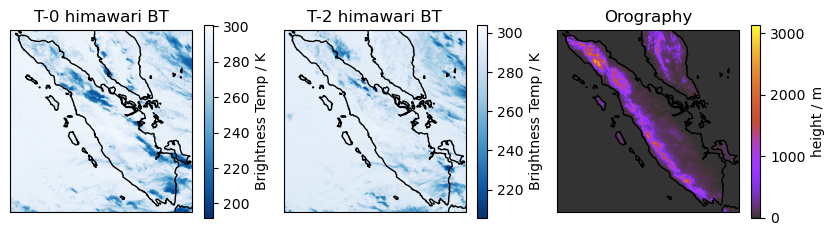

In [4]:
# visualise the data
fig = plt.figure(figsize=(10,5))

blues_r = mpl.cm.get_cmap('Blues_r')

ax = fig.add_subplot(131, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
img=ax.imshow(T_0_data, origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap=blues_r)
#ax.pcolor(data[::-1], cmap=cmap,edgecolors='k', linewidths=1, transform = ccrs.PlateCarree())
ax.set_title('T-0 himawari BT')
plt.colorbar(img, shrink=0.5, label='Brightness Temp / K')

ax = fig.add_subplot(132, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
img=ax.imshow(T_2_data, origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap=blues_r)
ax.set_title('T-2 himawari BT')
plt.colorbar(img, shrink=0.5, label='Brightness Temp / K')

ax = fig.add_subplot(133, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
img = ax.imshow(orog_data, origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='gnuplot', alpha=0.8)
ax.set_title('Orography')
plt.colorbar(img, shrink=0.5, label='height / m')

plt.show()

## c) Prepare input

In [5]:
# calculate the number of prediction grids that fit into the domain
no_x_grids = T_0_data.shape[0]/no_of_pixels_per_prediction_grid
no_y_grids = T_0_data.shape[1]/no_of_pixels_per_prediction_grid

# checks that a whole number of prediction grids fits into the domain
# important to choose a no_of_pixels_per_prediction_grid value that is a multiple of domain dimensions
if (no_x_grids != int(no_x_grids)) or (no_y_grids != int(no_y_grids)):
    print('Prediction grid pixel resolution must be a multiple of input data dimension')

# produces the input data for each prediction tile across the domain
T_0_tiles = generate_tiles(T_0_data, no_x_grids, no_y_grids, no_of_pixels_per_prediction_grid, 1)
T_2_tiles = generate_tiles(T_2_data, no_x_grids, no_y_grids, no_of_pixels_per_prediction_grid, 1)
orog_tiles = generate_tiles(orog_data, no_x_grids, no_y_grids, no_of_pixels_per_prediction_grid, 1)

# change in BT over the previous 2 hours
T_change = T_2_tiles-T_0_tiles

# input data is: T_0, T_change and Orography
input_data = np.stack([T_0_tiles, T_change, orog_tiles])

print(input_data.shape)

(3, 324, 63, 63)


## d) Load SII-NowNet model and generate nowcast

In [12]:
# load the pre-trained intensification model
intens_path = './tools/models/intensification/' + str(lead_time) + '_model'
intens_model = load_model(intens_path)

# load the pre-trained initiation model
init_path = './tools/models/initiation/' + str(lead_time) + '_model'
init_model = load_model(init_path)

# normalise the values
norm_input = prepare_test_input(input_data)

# norm_input must be of shape (total number of prediction grids x number of X pixels x number of Y pixels x number of channels)
print(norm_input.shape)

# produce the nowcasts
intens_predictions = intens_model.predict(norm_input, verbose=0)[:,0]
intens_nowcast = intens_predictions.reshape(int(no_x_grids-2),int(no_y_grids-2))
sumatra_intens_nowcast = np.pad(intens_nowcast, 1, mode='constant', constant_values=np.nan)

init_predictions = init_model.predict(norm_input, verbose=0)[:,0]
init_nowcast = init_predictions.reshape(int(no_x_grids-2),int(no_y_grids-2))
sumatra_init_nowcast = np.pad(init_nowcast, 1, mode='constant', constant_values=np.nan)

(324, 63, 63, 3)


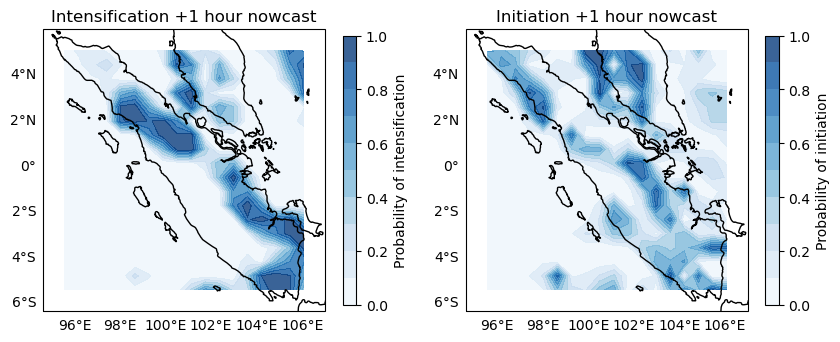

In [18]:
#Plot the results

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(121, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
img = ax.contourf(sumatra_intens_nowcast, levels=10,origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='Blues',alpha=0.8)
ax.set_title('Intensification +' + str(lead_time) + ' hour nowcast')
plt.colorbar(img, shrink=0.35, label='Probability of intensification')
gl = ax.gridlines(draw_labels=True, linewidth=0)  
gl.top_labels = gl.right_labels = False

ax = fig.add_subplot(122, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
img=ax.contourf(sumatra_init_nowcast, levels=10,origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='Blues',alpha=0.8)
ax.set_title('Initiation +' + str(lead_time) + ' hour nowcast')
plt.colorbar(img, shrink=0.35, label='Probability of initiation')
gl = ax.gridlines(draw_labels=True, linewidth=0)  
gl.top_labels = gl.right_labels = False

plt.show()

## e) Repeat for Java

In [80]:
min_lat = -9
max_lat = -5.28
min_lon = 104.67
max_lon = 114.6

In [81]:
T_0_data = np.load('./tools/test_data/jakarta/Jak_T_0_data.npy')
T_2_data = np.load('./tools/test_data/jakarta/Jak_T_2_data.npy')
orog_data = np.load('./tools/test_data/jakarta/Jak_orog_data.npy')

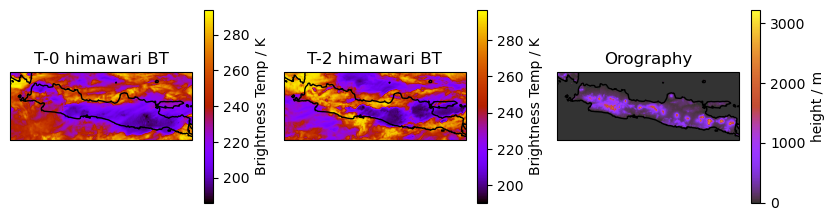

In [82]:
# visualise the data
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(131, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
img=ax.imshow(T_0_data, origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='gnuplot')
#ax.pcolor(data[::-1], cmap=cmap,edgecolors='k', linewidths=1, transform = ccrs.PlateCarree())
ax.set_title('T-0 himawari BT')
plt.colorbar(img, shrink=0.5, label='Brightness Temp / K')

ax = fig.add_subplot(132, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
img=ax.imshow(T_2_data, origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='gnuplot')
ax.set_title('T-2 himawari BT')
plt.colorbar(img, shrink=0.5, label='Brightness Temp / K')

ax = fig.add_subplot(133, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
img = ax.imshow(orog_data, origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='gnuplot', alpha=0.8)
ax.set_title('Orography')
plt.colorbar(img, shrink=0.5, label='height / m')

plt.show()

In [83]:
# calculate the number of prediction grids that fit into the domain
no_x_grids = T_0_data.shape[0]/no_of_pixels_per_prediction_grid
no_y_grids = T_0_data.shape[1]/no_of_pixels_per_prediction_grid

# checks that a whole number of prediction grids fits into the domain
# important to choose a no_of_pixels_per_prediction_grid value that is a multiple of domain dimensions
if (no_x_grids != int(no_x_grids)) or (no_y_grids != int(no_y_grids)):
    print('Prediction grid pixel resolution must be a multiple of input data dimension')

else:
    # produces the input data for each prediction tile across the domain
    T_0_tiles = generate_tiles(T_0_data, no_x_grids, no_y_grids, no_of_pixels_per_prediction_grid, 1)
    T_2_tiles = generate_tiles(T_2_data, no_x_grids, no_y_grids, no_of_pixels_per_prediction_grid, 1)
    orog_tiles = generate_tiles(orog_data, no_x_grids, no_y_grids, no_of_pixels_per_prediction_grid, 1)
    
    # change in BT over the previous 2 hours
    T_change = T_2_tiles-T_0_tiles
    
    # input data is: T_0, T_change and Orography
    input_data = np.stack([T_0_tiles, T_change, orog_tiles])
    
    print(input_data.shape)

(3, 56, 63, 63)


In [84]:
# load the pre-trained intensification model
intens_path = './tools/models/intensification/' + str(lead_time) + '_model'
intens_model = load_model(intens_path)

# load the pre-trained initiation model
init_path = './tools/models/initiation/' + str(lead_time) + '_model'
init_model = load_model(init_path)

# normalise the values
norm_input = prepare_test_input(input_data)

# norm_input must be of shape (total number of prediction grids x number of X pixels x number of Y pixels x number of channels)
print(norm_input.shape)

# produce the nowcasts
intens_predictions = intens_model.predict(norm_input, verbose=0)[:,0]
intens_nowcast = intens_predictions.reshape(int(no_x_grids-2),int(no_y_grids-2))
java_intens_nowcast = np.pad(intens_nowcast, 1, mode='constant', constant_values=np.nan)

init_predictions = init_model.predict(norm_input, verbose=0)[:,0]
init_nowcast = init_predictions.reshape(int(no_x_grids-2),int(no_y_grids-2))
java_init_nowcast = np.pad(init_nowcast, 1, mode='constant', constant_values=np.nan)

(56, 63, 63, 3)


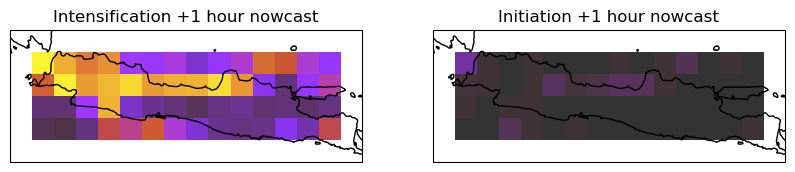

In [85]:
#Plot the results

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(121, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
ax.imshow(java_intens_nowcast, origin = 'lower', vmin=0, vmax=1, extent = (min_lon, max_lon, min_lat, max_lat), cmap='gnuplot',alpha=0.8)
ax.set_title('Intensification +1 hour nowcast')

ax = fig.add_subplot(122, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
ax.imshow(java_init_nowcast, origin = 'lower', vmin=0, vmax=1, extent = (min_lon, max_lon, min_lat, max_lat), cmap='gnuplot',alpha=0.8)
ax.set_title('Initiation +1 hour nowcast')

plt.show()

# PART 2: Verification

In [86]:
region = 'java'

In [87]:
# in order to verify the nowcast you need to himawari BT at at the valid time (only possible if looking at historical cases) and 1 hour before the valid time
# load the BT data at the valid time

if region == 'sumatra':

    max_lon = 107
    min_lon = 94.63
    max_lat = 5.98
    min_lat = -6.38

    T_valid_cube = np.load('./tools/test_data/T_valid_cube.npy')
    T_0_data = np.load('./tools/test_data/T_0_data.npy')
    intens_nowcast = sumatra_intens_nowcast.copy()
    init_nowcast = sumatra_init_nowcast.copy()

elif region == 'java':

    min_lat = -9
    max_lat = -5.28
    min_lon = 104.67
    max_lon = 114.6
    
    T_valid_cube = np.load('./tools/test_data/jakarta/Jak_valid_data.npy')
    T_0_data = np.load('./tools/test_data/jakarta/Jak_T_0_data.npy')
    intens_nowcast = java_intens_nowcast.copy()
    init_nowcast = java_init_nowcast.copy()



data = np.stack([T_0_data, T_valid_cube]) 

df_init = initiation_target_generator(data, 
                                      time, 
                                      20, 
                                      0.05, 
                                      235, 
                                      20, 
                                      0.05, 
                                      21)

df_intens = intensification_target_generator(data, 
                                             time,
                                             20, 
                                             0.05,
                                             235,
                                             21)

observed_intens = np.where(df_intens['scaled_convection_target'][0]==0,np.nan,1)[1:-1,1:-1]
observed_intens = np.pad(observed_intens, ((1,1),(1,1)), constant_values=np.nan)

observed_inits = np.where(df_init['scaled_convection_target'][0]==0,np.nan,1)[1:-1,1:-1]
observed_inits = np.pad(observed_inits, ((1,1),(1,1)), constant_values=np.nan)

## Visualise

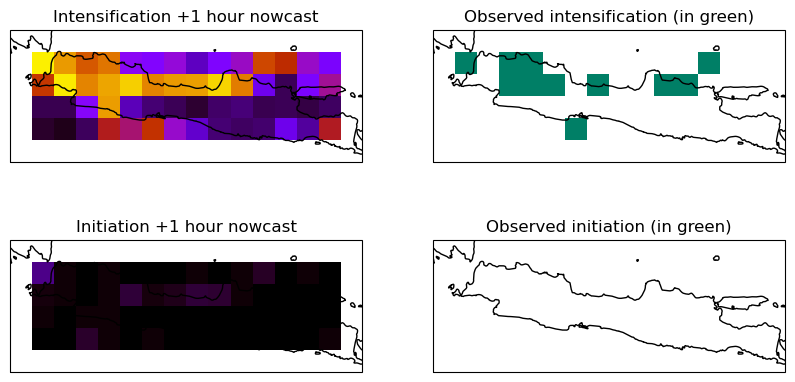

In [88]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(221, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
ax.imshow(intens_nowcast, origin = 'lower',vmin=0, vmax=1, extent = (min_lon, max_lon, min_lat, max_lat), cmap='gnuplot')
ax.set_title('Intensification +1 hour nowcast')

ax = fig.add_subplot(222, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
ax.imshow(observed_intens, origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='summer')
#ax.imshow(np.where(df_intens['scaled_convection_target'][0]==0,np.nan,1), origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='summer')
ax.set_title('Observed intensification (in green)')

ax = fig.add_subplot(223, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
ax.imshow(init_nowcast, origin = 'lower', vmin=0,vmax=1, extent = (min_lon, max_lon, min_lat, max_lat), cmap='gnuplot')
ax.set_title('Initiation +1 hour nowcast')

ax = fig.add_subplot(224, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
ax.imshow(observed_inits, origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='summer')
ax.set_title('Observed initiation (in green)')

plt.show()
